# Packages inladen

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# installeer lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Data exploration

In [54]:
df = pd.read_csv("DATA_4.03_MNT.csv")
df.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [55]:
# We zien dat minder van de helft kapot is en dat de meeste datapunten zijn verzameld onder 60 (lifetime) 
# terwijl de maximale waarde van lifetime 93 is. 
df.describe()

,lifetime,broken,pressureInd,moistureInd,temperatureInd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.195000,0.397000,98.599338,99.376723,100.628541
std,26.472737,0.489521,19.964052,9.988726,19.633060
min,1.000000,0.000000,33.481917,58.547301,42.279598
25%,34.000000,0.000000,85.558076,92.771764,87.676913
50%,60.000000,0.000000,97.216997,99.433959,100.592277
75%,80.000000,1.000000,112.253190,106.120762,113.662885
max,93.000000,1.000000,173.282541,128.595038,172.544140


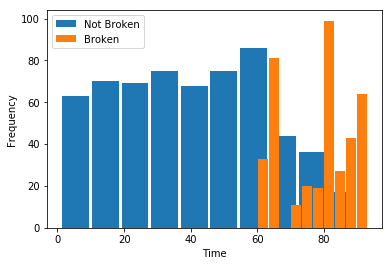

In [56]:
df.lifetime.loc[df.broken == 0].hist(rwidth = 0.9)
df.lifetime.loc[df.broken == 1].hist(rwidth = 0.9, grid = False)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend(["Not Broken", "Broken"])
plt.show()

In [57]:
# Het schalen van features zodat ze in de zelfde orde van magnitude zijn met andere features
df_scaled = df
df_scaled.loc[:, ["pressureInd", "moistureInd", "temperatureInd"]] = df_scaled.loc[:, ["pressureInd", "moistureInd", "temperatureInd"]]/100

# Dummy variabelen aanmaken voor de categorische variabelen
df_dummied = pd.get_dummies(df_scaled, drop_first = False, prefix = "", prefix_sep ="")
df_dummied.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,TeamA,TeamB,TeamC,Provider1,Provider2,Provider3,Provider4
0,56,0,0.921789,1.042302,0.965172,1,0,0,0,0,0,1
1,81,1,0.720759,1.030657,0.872711,0,0,1,0,0,0,1
2,60,0,0.962723,0.778014,1.121962,1,0,0,1,0,0,0
3,86,1,0.944065,1.084936,0.720254,0,0,1,0,1,0,0
4,34,0,0.977529,0.994135,1.037563,0,1,0,1,0,0,0


Voor regressie doen we een test om te kijken of alle variabelen onafhankelijk van elkaar zijn, maar we weten bij dummies dat dat niet zo is. Als variabele `TeamA` en `Provider1` worden meegenomen, dan zijn de dummies niet meer variabel.

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y, X = dmatrices("""lifetime ~ broken + pressureInd + moistureInd + temperatureInd 
                    + TeamB + TeamC + Provider2 + Provider3 + Provider4
                    + TeamA + Provider1""", data=df_dummied, return_type='dataframe')
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variable,VIF
0,Intercept,0.000000
1,broken,1.022236
2,pressureInd,1.012341
3,moistureInd,1.006358
4,temperatureInd,1.001888
5,TeamB,inf
6,TeamC,inf
7,Provider2,inf
8,Provider3,inf
9,Provider4,inf


# Survival Analysis
## Kaplan Meier

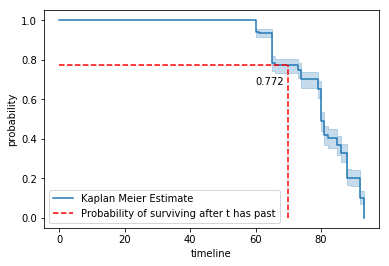

In [42]:
# Fit kaplan meier curve
kmf = KaplanMeierFitter()
kmf.fit(df.lifetime, df.broken, label='Kaplan Meier Estimate')
# Plot KM curve
kmf.plot(ci_show=True)
plt.ylabel("probability")

# Predict survival probability and plot in KM curve
t = 70
plt.plot([t, t], [0, kmf.predict(t)], "r--")
plt.plot([0, t], [kmf.predict(t), kmf.predict(t)], "r--", label = "Probability of surviving after t has past")
plt.text(max(1, t-10), max(0.01, kmf.predict(t)-0.1), "{:.3f}".format(kmf.predict(t)))
plt.legend()
plt.show()

## Cox Proportional Hazard Regression

In [65]:
from sklearn.model_selection import train_test_split

df_filter = df_dummied.drop(["TeamA", "Provider1"], axis = 1)
train, test = train_test_split(df_filter, test_size = 0.25, random_state = 1)
train.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,TeamB,TeamC,Provider2,Provider3,Provider4
298,17,0,0.773020,0.952453,1.024545,0,0,0,0,1
160,29,0,1.127450,0.916177,1.009546,1,0,0,0,1
268,45,0,0.767686,0.986989,0.907500,1,0,0,0,0
658,35,0,1.153062,1.059267,0.751906,1,0,0,1,0
996,88,1,1.167271,1.108713,0.950756,0,0,0,0,1


In [105]:
cr = CoxPHFitter()
cr.fit(train, duration_col = "lifetime", event_col = "broken", step_size = .01)
cr.print_summary()

<lifelines.CoxPHFitter: fitted with 750 observations, 463 censored>
      duration col = 'lifetime'
         event col = 'broken'
number of subjects = 750
  number of events = 287
    log-likelihood = -907.48
  time fit was run = 2020-09-19 10:44:08 UTC

---
                coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
pressureInd     0.14       1.15      0.31   0.44   0.66      0.60       -0.47        0.74
moistureInd    -0.69       0.50      0.61  -1.13   0.26      1.95       -1.89        0.51
temperatureInd  1.31       3.72      0.33   3.92 <0.005     13.48        0.66        1.97
TeamB          -0.00       1.00      0.14  -0.02   0.99      0.02       -0.29        0.28
TeamC           2.73      15.38      0.23  11.70 <0.005    102.68        2.28        3.19
Provider2      -5.68       0.00      0.41 -13.95 <0.005    144.43       -6.48       -4.88
Provider3       4.85     127.45      0.39  12.59 <0.005    118.35        4.09        5.60
Provider4      -4.15 

C:\Users\simch\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:531: ConvergenceWarning: Newton-Rhapson failed to converge sufficiently in 50 steps.
  warnings.warn("Newton-Rhapson failed to converge sufficiently in %d steps." % max_steps, ConvergenceWarning)


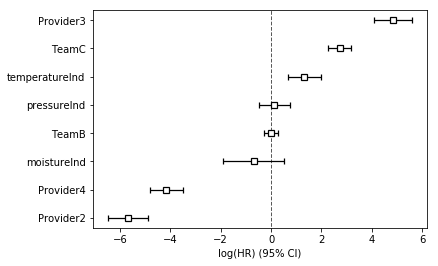

In [76]:
cr.plot()

In [118]:
# Only evaluate on the broken machines. There is no way to check if we predicted the machines correct if they haven't broken yet
broken = test.loc[test.broken == 1, "lifetime"]
pred = cr.predict_median(test).iloc[:, 0].loc[test.broken == 1]

RMSE: 0.853


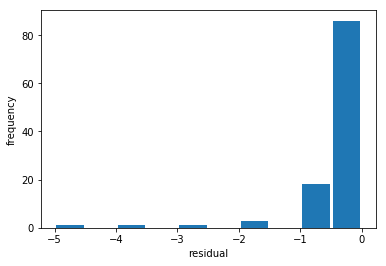

In [119]:
RMSE = lambda ytrue, ypred: sum((ytrue-ypred)**2/(len(ytrue)))**0.5
print("RMSE: {:.3f}".format(RMSE(broken.values, pred.values)))
res = broken-pred
plt.hist(res, rwidth = 0.9)
plt.xlabel("residual")
plt.ylabel("frequency")
plt.show()

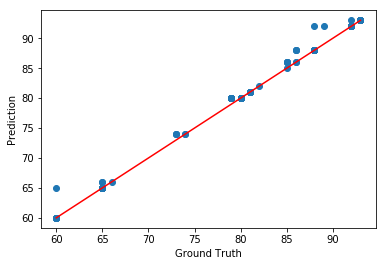

In [120]:
plt.scatter(broken, pred)
plt.plot([broken.min(), broken.max()], [broken.min(), broken.max()], "r")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()